In [90]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json

import os
import re
import util
import cam
import model
import draw

VID_ROOT = '/home/akarshkumar0101/Insync/akarshkumar0101@gmail.com/Google Drive/nba-3d-data/harden/'
DATA_ROOT = '/home/akarshkumar0101/Insync/akarshkumar0101@gmail.com/Google Drive/nba-3d-data/'

img_shape = plt.imread(VID_ROOT+'/all_views/frame_00001.png').shape[:2]

uf_mat_int_default = cam.get_intrinsic_mat_default()
uf_mat_int = cam.get_intrinsic_mat_for_img_shape(img_shape)

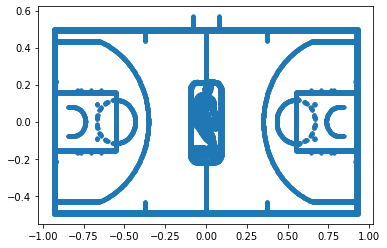

In [17]:
img = plt.imread(VID_ROOT+'/view_0/frame_00089.png')
img = (img*255/img.max()).astype(np.uint8)

court_img, court_bin = model.load_model_img(DATA_ROOT)
court_img = (court_img*255/court_img.max()).astype(np.uint8)

mat_model = model.get_mat_model(model.load_model_corners(DATA_ROOT))

X_w = model.calc_model_world_coordinates(DATA_ROOT)
plt.scatter(X_w[:, 0], X_w[:, 1], marker='.');plt.show()

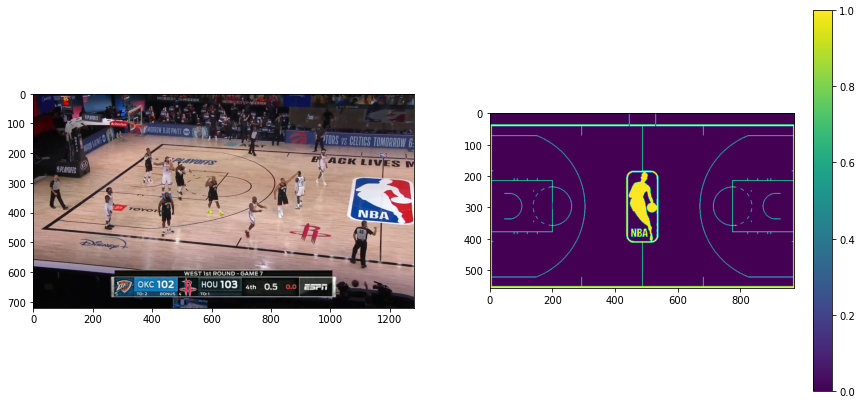

In [13]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(court_bin);plt.colorbar();plt.show()

In [14]:
import json
import numpy as np
with open('/home/akarshkumar0101/nba-3d-data/harden/init_views.json') as f:
    data = json.load(f)
data = np.array(data)
# keypoint correspondance data
# data has shape [view, {image/model}, 4, {x, y}]
print(data.shape)

(3, 2, 4, 2)


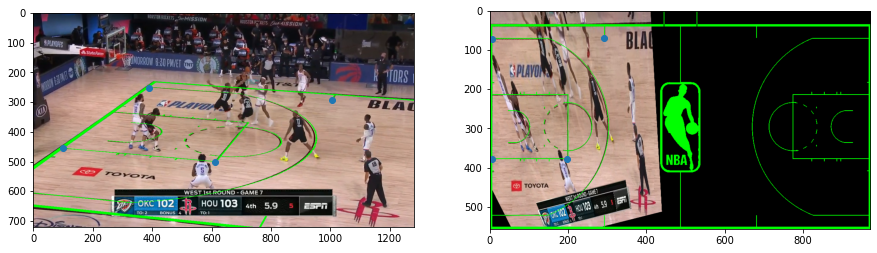

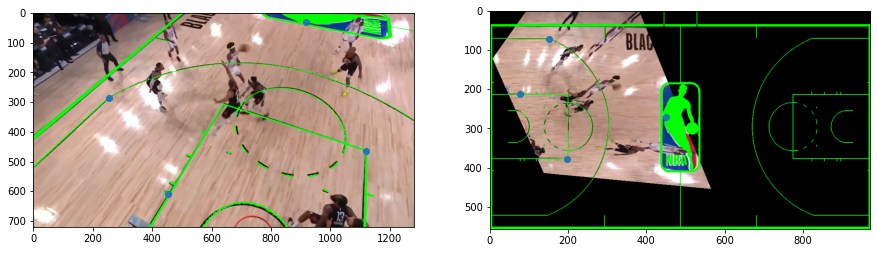

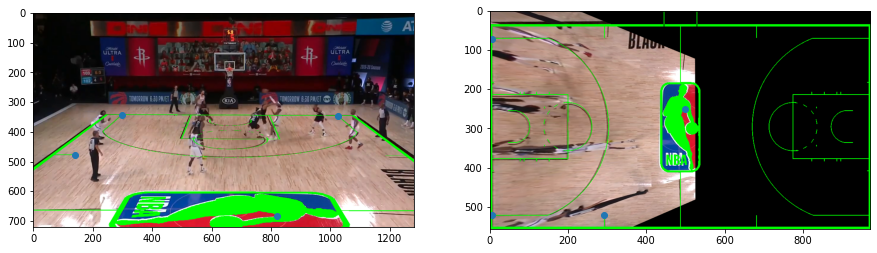

In [15]:
for view_idx in range(3):
    img = plt.imread(VID_ROOT+f'/view_{view_idx}/frame_00000.png')
    img = (img*255/img.max()).astype(np.uint8)
    src = data[view_idx, 0]
    dst = data[view_idx, 1]
    H, _ = cv2.findHomography(src, dst, )

    plt.figure(figsize=(15,7))
    plt.subplot(121)
    courtt = cv2.warpPerspective(court_img, H, dsize=img.shape[:2][::-1], flags=cv2.WARP_INVERSE_MAP)
    courtt = courtt[..., :3].mean(axis=-1)>180
    imgt = img.copy()
    imgt[courtt, :] = 0.
    imgt[courtt, 1] = 255.
    imgt = np.clip(imgt, 0, 255)
    plt.scatter(src[:, 0], src[:, 1], marker='o')
    plt.imshow(imgt)
    
    plt.subplot(122)
    imgt = cv2.warpPerspective(img, H, dsize=court_img.shape[:2][::-1])
    imgt[court_bin, :] = 0.
    imgt[court_bin, 1] = 255.
    imgt = np.clip(imgt, 0, 255)
    plt.scatter(dst[:, 0], dst[:, 1])
    plt.imshow(imgt)
    
    plt.show()
    

In [158]:
view_idx = 0
mat_int = cam.apply_focus(5., uf_mat_int)[:, :3]
#view 0 focus: 5
#view 1 focus: 1
#view 2 focus: 2

In [159]:
X_i_kp = data[view_idx, 0].astype(np.float64)
X_m_kp = data[view_idx, 1].astype(np.float64)
X_m_kp = np.concatenate([X_m_kp, np.zeros((len(X_m_kp), 1))], axis=-1)

X_w_kp = util.from_homo((mat_model@util.to_homo(X_m_kp)[..., None])[..., 0])

# cv2.solvePnP(model_pts, cam_pts, K, np.zeros((4,1)))

retval, R, T = cv2.solvePnP(X_w_kp, X_i_kp, mat_int, np.zeros((4,1)), flags=cv2.SOLVEPNP_IPPE)

R, _ = cv2.Rodrigues(R)

In [160]:
X_c = (R@X_w[..., None])+T
X_i = mat_int[:, :3]@X_c
X_i = util.from_homo(X_i[..., 0])

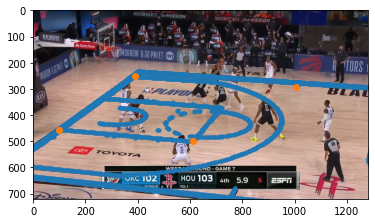

In [161]:
plt.scatter(X_i[::2, 0], X_i[::2, 1], marker='.')
draw.set_img_bounds(img_shape)
plt.imshow(plt.imread(VID_ROOT+f'/view_{view_idx}/frame_00000.png'))
plt.scatter(X_i_kp[:, 0], X_i_kp[:, 1])

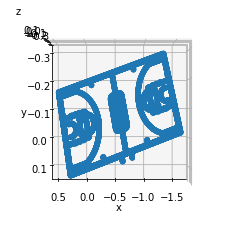

In [120]:
ax = plt.subplot(projection='3d')
ax.scatter3D(X_c[..., 0, 0], X_c[..., 1, 0], X_c[..., 1, 0])
ax.set_xlabel('x');ax.set_ylabel('y');ax.set_zlabel('z')
ax.view_init(90, 90)

In [108]:
retval, rotations, translations, normals = cv2.decomposeHomographyMat(M, np.eye(3))
R = rotations[0]
T = translations[0]

In [ ]:
P@C@M = H

In [ ]:
P@C = HMinv

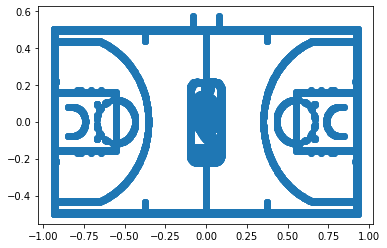

In [100]:

Xp = (R@(X[..., None])+T)[..., 0]
Xp = Xp[:, :2]/Xp[:, [2]]
plt.scatter(Xp[:, 0], Xp[:, 1])

In [79]:
X.shape

(37697, 3)

In [77]:
y, x = np.where(court_bin)
X = np.stack([x, y, np.zeros_like(x)], axis=-1)

array([[443,   0,   0],
       [444,   0,   0],
       [527,   0,   0],
       ...,
       [969, 556,   0],
       [970, 556,   0],
       [971, 556,   0]])